In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import factor_analyzer as fa
import copy

tss_df = pd.read_csv("data/combined_data.csv")
items_descr = pd.read_csv("data/description_items.csv")

tss_df.drop(columns="Unnamed: 0", inplace=True)

items_descr.set_index("Unnamed: 0", drop=True, inplace=True)
items_descr.index.set_names("item_label", inplace=True)
items_descr = pd.Series(items_descr.iloc[:, 0], name="item description")

tss_df.head(3)

,response_id,story_id,prompt_label,preset_label,sample,tss_coh_1,tss_coh_2,tss_coh_3,tss_coh_4,tss_coh_5,...,start,end,duration_in_sec,recorded,tss_order,qual_check_1,qual_check_1_order,qual_check_2,pass_qual_1,pass_qual_2
0,R_3LZPTbqxmeWvp7w,GEN_HF_6,High Fantasy,Genesis,Community,2.0,4.0,4.0,4.0,4.0,...,2022-02-17 07:41:22,2022-02-17 07:58:46,1044,2022-02-17 07:58:47,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN
1,R_3CCMkj9T7UgOtgP,ALL_HR_3,Historical Romance,All-Nighter,Community,2.0,4.0,2.0,1.0,2.0,...,2022-02-17 07:52:11,2022-02-17 08:01:19,548,2022-02-17 08:01:20,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN
2,R_3PBKFhmDXlAQNO6,ALL_HOR_2,Horror,All-Nighter,Community,5.0,5.0,1.0,1.0,3.0,...,2022-02-17 07:55:22,2022-02-17 08:03:16,473,2022-02-17 08:03:16,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN


In [5]:
item_labels_li = [
    'tss_coh_1', 'tss_coh_2', 'tss_coh_3', 'tss_coh_4',
    'tss_coh_5', 'tss_coh_6', 'tss_coh_7', 'tss_coh_8', 'tss_coh_9',
    'tss_coh_10', 'tss_coh_11', 'tss_coh_12', 'tss_conch_1', 'tss_conch_2',
    'tss_conch_3', 'tss_conch_4', 'tss_conch_5', 'tss_conch_6',
    'tss_conch_7', 'tss_conch_8', 'tss_cre_1', 'tss_cre_2', 'tss_cre_3',
    'tss_cre_4', 'tss_cre_5', 'tss_cre_6', 'tss_cre_7', 'tss_cre_8',
    'tss_cre_9', 'tss_cre_10', 'tss_cre_11', 'tss_cre_12', 'tss_qua_1',
    'tss_qua_2', 'tss_qua_3', 'tss_qua_4', 'tss_qua_5', 'tss_qua_6',
    'tss_qua_7', 'tss_qua_8', 'tss_rep_1', 'tss_rep_2', 'tss_rep_3',
    'tss_rep_4', 'tss_rep_5', 'tss_rep_6', 'tss_rep_7', 'tss_rep_8',
    'tss_rep_9', 'tss_rep_10', 'tss_rep_11', 'tss_rep_12', 'tss_sty_1',
    'tss_sty_2', 'tss_sty_3', 'tss_sty_4', 'tss_sty_5', 'tss_sty_6',
    'tss_sty_7', 'tss_sty_8', 'tss_sty_9', 'tss_sty_10', 'tss_sty_11',
    'tss_sty_12', 'tss_pac_1', 'tss_pac_2', 'tss_pac_3', 'tss_pac_4',
    'tss_pac_5', 'tss_pac_6', 'tss_pac_7', 'tss_pac_8', 'tss_pac_9'
]

In [6]:
# Check missing data patterns
missing = tss_df[item_labels_li].isna()
print("Top 5 cols with missing data per col:")
print(missing.sum().sort_values(ascending = False).head(5))
print("\nTop 5 missing data per row:")
print(missing.sum(axis=1).sort_values(ascending = False).head(5))

# in this case it is straightforward - just drop the 2 rows with missing data
tss_df.dropna(subset=item_labels_li, inplace=True)

# if missing data should be more common with small amounts of missing data per case, might need different approach obv

Top 5 cols with missing data per col:
tss_coh_1     2
tss_rep_9     2
tss_cre_8     2
tss_cre_10    2
tss_qua_2     2
dtype: int64

Top 5 missing data per row:
117    72
77     35
0       0
124     0
116     0
dtype: int64


In [7]:
# check if items are appropriate for EFA
# correlations mostly |.3|-|.8|
items_corr = tss_df[item_labels_li].corr()

extreme_corrs_count_dict = {}
high_corr_li = []

# print out extreme corrs
total_report = ""
for index, row in items_corr.iterrows():
    variable1 = index
    corrs = row
    i = 0
    count = 0
    for variable2, corr in corrs.iteritems():
        if (variable1 != variable2) and ((abs(corr) < 0.3) or (abs(corr) > 0.8)):
            count += 1
            if abs(corr) > 0.8:
                high_corr_li.append((variable1, variable2, corr))
        i += 1
    extreme_corrs_count_dict[variable1] = count

extreme_corrs_count = pd.Series(extreme_corrs_count_dict)
print("Descriptives for extreme correlation count:")
print(extreme_corrs_count.describe())

# uhmm that are more extreme correlations as I would like
# but maybe subscales are fairly orthogonal?

Descriptives for extreme correlation count:
count    73.000000
mean     50.301370
std      10.310034
min      27.000000
25%      42.000000
50%      52.000000
75%      58.000000
max      70.000000
dtype: float64


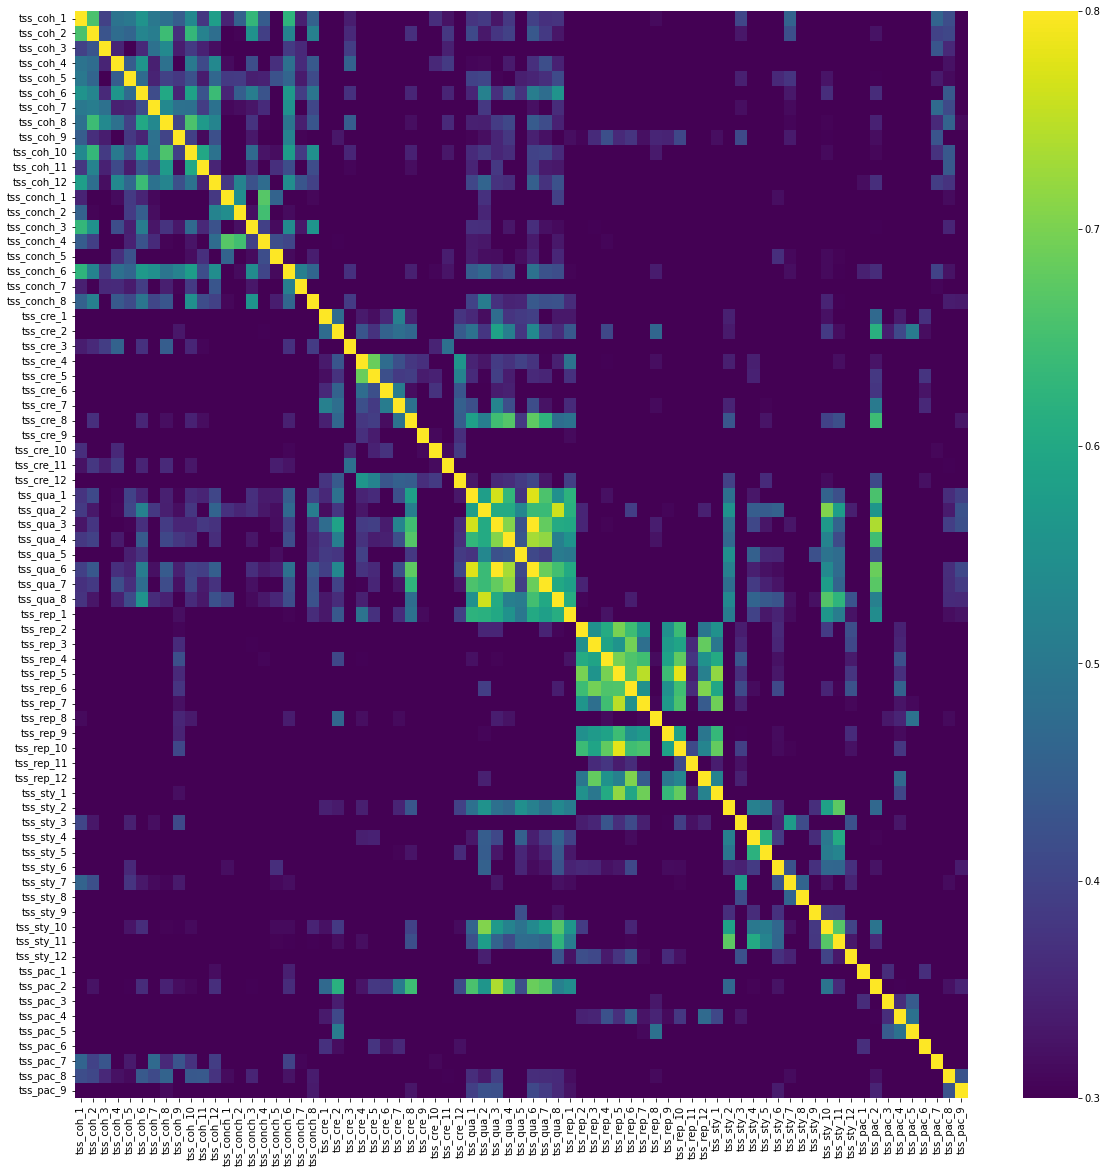

In [8]:
# Let us look at a heatmap (absolute values of correlations)
fig, ax = plt.subplots(figsize=(20, 20))

ax = sns.heatmap(abs(items_corr),
                 xticklabels=items_corr.columns.values,
                 yticklabels=items_corr.columns.values,
                 ax=ax, cmap="viridis", vmin=0.3, vmax=0.8)

# most item clusters are just surprising orthogonal (which is actually nice)

In [9]:
# Inspect suspicious items with low correlations here
susp_items = [
    "tss_cre_9", "tss_cre_10"
    "tss_rep_8",
    "tss_sty_8", "tss_sty_9"
    "tss_pac_1", "tss_pac_3", "tss_pac_5", "tss_pac_6"
]

for index, row in items_corr.iterrows():
    if index in susp_items:
        print("{}: {}".format(index, items_descr[index]))
        print("Correlations >= .3:")
        if row[(row >= .3) & (row.index != index)].empty:
            print("NONE - ALL correlations are < .3!")
        else:
            print(row[(row > .3) & (row.index != index)].to_string())
        print("")

tss_cre_9: The setting of the story was original.
Correlations >= .3:
tss_cre_4     0.366645
tss_cre_5     0.338780
tss_cre_10    0.309996
tss_cre_12    0.364948
tss_rep_1     0.312869

tss_sty_8: The writing style was too complicated to be understood easily.
Correlations >= .3:
tss_sty_3    0.41377

tss_pac_3: It took a long time for things to happen in the story.
Correlations >= .3:
tss_cre_2    0.340185
tss_rep_8    0.332453
tss_pac_4    0.363124
tss_pac_5    0.440753

tss_pac_5: Nothing seemed to be happening in the story.
Correlations >= .3:
tss_cre_2    0.505797
tss_rep_7    0.309941
tss_rep_8    0.483983
tss_pac_3    0.440753
tss_pac_4    0.486108

tss_pac_6: There was plenty of action in the story.
Correlations >= .3:
tss_cre_1     0.369002
tss_cre_5     0.376025
tss_cre_6     0.326536
tss_cre_7     0.355461
tss_cre_12    0.320081
tss_pac_1     0.365212



In [10]:
# Consider excluding variables with lots correlations < .3
items_analysis_li = copy.deepcopy(item_labels_li)

excluded_items_li = [
    "tss_sty_8"
]

for item in excluded_items_li:
    items_analysis_li.remove(item)

In [11]:
# Check for multicollinearity
def reduce_multicoll(df, vars_li, vars_descr = [], print_details = True):
    reduced_vars = copy.deepcopy(vars_li)
    print("Beginning check for multicollinearity")
    vars_corr = df[reduced_vars].corr()
    det = np.linalg.det(vars_corr)
    print("\nDeterminant of initial correlation matrix: {}\n".format(det))

    if det > .00001:
        print("Determinant is > .00001. No issues with multicollinearity detected.")
        return(reduced_vars)

    print("Starting to remove redundant variables by acessing mutlicollinearity with VIF...\n")
    count_missing = len(df) - len(df.dropna(subset=vars_li))
    if count_missing > 0:
        print("This requries dropping missing values.",
              "The following procedure will ignore {} cases with missing values".format(count_missing))
    while det <= .00001:
        # could implement pairwise dropping of missing here at some point
        # but until you have a case with lots of missing data, this will work fine
        x_df = df.dropna(subset=vars_li)[reduced_vars]
        vifs = [vif(x_df.values, i)
                          for i in range(len(x_df.columns))]
        vif_data = pd.Series(vifs, index=x_df.columns)
        vif_max = (vif_data.idxmax(), vif_data.max())
        
        if print_details:
            print("Excluded item {}. VIF: {:.2f}".format(vif_max[0], vif_max[1]))
            
            if len(vars_descr) > 0:
                print("('{}')".format(vars_descr[vif_max[0]]))
            print("")
        
        reduced_vars.remove(vif_max[0])
        
        vars_corr = df[reduced_vars].corr()
        det = np.linalg.det(vars_corr)
    
    print("Done! Determinant is now: {:.6f}".format(det))
    count_removed = len(vars_li) - len(reduced_vars)
    print("I have excluded {} redunant items with {} items remaining".format(count_removed, len(reduced_vars)))
    
    return(reduced_vars)

In [12]:
items_analysis_li = reduce_multicoll(tss_df, items_analysis_li, vars_descr = items_descr, print_details = True)

Beginning check for multicollinearity

Determinant of initial correlation matrix: 1.475134825403836e-26

Starting to remove redundant variables by acessing mutlicollinearity with VIF...

Excluded item tss_qua_3. VIF: 49.65
('The story was fun to read.')

Excluded item tss_coh_12. VIF: 46.88
('The story lacked logic.')

Excluded item tss_coh_1. VIF: 40.83
('I had a hard time making sense of what was going on in the story.')

Excluded item tss_cre_5. VIF: 36.85
('The story was imaginative.')

Excluded item tss_cre_2. VIF: 34.35
('The story was boring.')

Excluded item tss_qua_6. VIF: 33.99
('I liked this story.')

Excluded item tss_rep_12. VIF: 29.76
('Particular words were used too often in the story.')

Excluded item tss_rep_4. VIF: 29.71
('The story was very repetitive.')

Excluded item tss_rep_5. VIF: 29.07
('In the story, the same things happened again and again.')

Excluded item tss_conch_1. VIF: 28.65
('Descriptions of characters in the story were consistent.')

Excluded item tss_

In [13]:
tss_df[items_analysis_li]

,tss_coh_2,tss_coh_5,tss_coh_6,tss_coh_9,tss_coh_11,tss_conch_4,tss_conch_7,tss_conch_8,tss_cre_3,tss_cre_6,...,tss_sty_5,tss_sty_9,tss_sty_10,tss_pac_1,tss_pac_3,tss_pac_5,tss_pac_6,tss_pac_7,tss_pac_8,tss_pac_9
0,4.0,4.0,4.0,1.0,2.0,3.0,3.0,2.0,2.0,4.0,...,3.0,4.0,5.0,2.0,2.0,1.0,4.0,2.0,2.0,4.0
1,4.0,2.0,2.0,1.0,4.0,2.0,5.0,2.0,1.0,3.0,...,2.0,2.0,1.0,5.0,1.0,2.0,2.0,2.0,4.0,2.0
2,5.0,3.0,1.0,4.0,2.0,4.0,1.0,1.0,1.0,4.0,...,2.0,1.0,1.0,4.0,1.0,1.0,4.0,5.0,2.0,2.0
3,4.0,4.0,2.0,1.0,5.0,3.0,3.0,2.0,1.0,4.0,...,3.0,4.0,4.0,4.0,2.0,1.0,2.0,4.0,4.0,2.0
4,1.0,2.0,1.0,4.0,4.0,2.0,5.0,2.0,2.0,2.0,...,3.0,1.0,1.0,5.0,1.0,1.0,3.0,3.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,2.0,4.0,4.0,2.0,4.0,2.0,3.0,3.0,2.0,4.0,...,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0
178,3.0,3.0,3.0,2.0,3.0,2.0,2.0,4.0,3.0,2.0,...,4.0,3.0,4.0,2.0,2.0,2.0,4.0,4.0,3.0,3.0
179,2.0,4.0,3.0,3.0,4.0,1.0,4.0,4.0,1.0,4.0,...,2.0,5.0,2.0,2.0,1.0,1.0,2.0,2.0,5.0,3.0
180,4.0,4.0,2.0,2.0,5.0,3.0,3.0,1.0,2.0,4.0,...,2.0,2.0,3.0,4.0,1.0,2.0,4.0,5.0,3.0,3.0


In [14]:
# Check Sampling Adequacy (KMO)
# (if SVD does not converge, dropna for participants with too many missing items)
# (might need to experiment how many missing are still okay)

tss_df.dropna(subset=items_analysis_li, thresh=1, inplace=True)

kmo = fa.factor_analyzer.calculate_kmo(tss_df[items_analysis_li])

print("Overall KMO: {}".format(kmo[1]))

i = 0
low_item_kmo = False
for item_kmo in kmo[0]:
    if item_kmo < .6:
        low_item_kmo = True
        item_label = item_labels_li[i]
        print("Low KMO for {} ('{}'): {}".format(
            item_label, items_descr[item_label], item_kmo))
    i += 1

if low_item_kmo == False:
    print("All item KMOs are >.6")

# Guidelines for KMO (Kaiser & Rice, 1974)
# Marvellous: values in the 0.90s
# Meritorious: values in the 0.80s
# Middling: values in the 0.70s
# Mediocre: values in the 0.60s
# Unacceptable: values in the 0.50s

Overall KMO: 0.8375937727959404
All item KMOs are >.6


In [19]:
# Determine number of factors
# Use Screeplot & Parallel Analysis

# Function to output results for parallel parallel analysis
def parallel_analysis(df, vars_li, k = 100, facs_to_display = 15):
    # EFA with no rotation to get EVs
    efa = fa.factor_analyzer.FactorAnalyzer(rotation=None)
    
    # EVs for actual data
    efa.fit(df[vars_li])
    ev_pca, ev_efa = efa.get_eigenvalues()
    
    # Prepare random data for parallel analysis
    n, m = df[vars_li].shape
    par_efa = fa.factor_analyzer.FactorAnalyzer(rotation=None)

    # Create df to store the values
    ev_par_df = pd.DataFrame(columns=range(1, m+1))

    # Run the fit 'k' times over a random matrix
    for runNum in range(0, k):
        par_efa.fit(np.random.normal(size=(n, m)))
        cur_ev_ser = pd.Series(par_efa.get_eigenvalues()[1], index=ev_par_df.columns)
        ev_par_df = ev_par_df.append(cur_ev_ser, ignore_index=True)
    # get 95th percentile for the evs
    par_95per = ev_par_df.quantile(0.95)
    
    # Draw graph
    plt.figure(figsize=(10, 6))

    # Line for eigenvalue 1
    plt.plot([1, facs_to_display+1], [1, 1], 'k--', alpha=0.3)
    # For the random data (parallel analysis)
    plt.plot(range(1, len(par_95per[:facs_to_display])+1),
             par_95per[:facs_to_display], 'b', label='EVs - random', alpha=0.4)
    # Markers and line for actual EFA eigenvalues
    plt.scatter(
        range(1, len(ev_efa[:facs_to_display])+1), ev_efa[:facs_to_display])
    plt.plot(range(1, len(ev_efa[:facs_to_display])+1),
             ev_efa[:facs_to_display], label='EVs - survey data')

    plt.title('Parallel Analysis Scree Plots', {'fontsize': 20})
    plt.xlabel('Components', {'fontsize': 15})
    plt.xticks(ticks=range(1, facs_to_display+1),
               labels=range(1, facs_to_display+1))
    plt.ylabel('Eigenvalue', {'fontsize': 15})
    plt.legend()
    plt.show()
    
    # Create simple table with values for 95th percentile for random data and EVs for actual data
    print("Factor eigenvalues for the 95th percentile of {} random matricesand for survey data for first {} factors:\n".
          format(k, facs_to_display))
    print("\033[1mFactor\tEV - random data 95h perc.\tEV survey data\033[0m")

    last_index = 0
    last_95per_par = 0
    last_ev_efa = 0
    found_threshold = False

    # Loop that prints previous (!) values
    # if current EV from survey data is smaller than 95th percentile from random data, we reached the threshold
    # in that case print the previous values in bold as it marks the number of factors determined by parallel analysis
    for index, cur_ev_par in par_95per[:facs_to_display].iteritems():
        cur_ev_efa = ev_efa[index-1]
        if (index > 1) & (cur_ev_par >= cur_ev_efa) & (found_threshold == False):
            found_threshold = True
            print("\033[1m{}\t{:.2f}\t\t\t\t{:.2f}\033[0m".format(
                last_index, last_95per_par, last_ev_efa))
        elif (index > 1):
            print("{}\t{:.2f}\t\t\t\t{:.2f}".format(
                last_index, last_95per_par, last_ev_efa))

        if index == len(par_95per[:facs_to_display]):
            print("{}\t{:.2f}\t\t\t\t{:.2f}".format(index, cur_ev_par, cur_ev_efa))

        last_index = index
        last_95per_par = cur_ev_par
        last_ev_efa = cur_ev_efa

In [ ]:
parallel_analysis(tss_df, items_analysis_li)

# determine factors to investigate based on screeplot and parallel analysis
# if both methods yield different results, examine both number of factors
# (decide for one based on whether you get a clean solution and on how interpretable the solution is)

In [148]:
# Decide on rotation (orthogonal: Varimax, oblique: Oblimin)

# Run orthogonal rotation
efa = fa.FactorAnalyzer(n_factors=4, rotation='varimax')
efa.fit(tss_df[items_analysis_li])
# Display rotation matrix
# Shows correlation between factors before rotation (rows) and after (columns)
print("Rotation Matrix (Orthogonal Rotation):")
print(efa.rotation_matrix_)
# If matrix is non-symetrical, this indicates that an oblique rotation is called for

# Run oblique rotation
efa = fa.FactorAnalyzer(n_factors=4, rotation='oblimin')
efa.fit(tss_df[items_analysis_li])
# Display factor correlation matrix
print("\nFactor Correlation Matrix (Oblique Rotation):")
print(efa.phi_)
# If matrix has clear correlations between factors, than this indicates the need for an oblique rotation
# if in doubt use oblique

Rotation Matrix (Orthogonal Rotation):
[[ 0.80482372  0.39475128 -0.4399519  -0.05359595]
 [-0.30188929  0.64545551  0.11127128 -0.69272559]
 [ 0.36040531  0.26151916  0.86645055  0.22578572]
 [-0.36225633  0.59930488 -0.20814532  0.68284664]]

Factor Correlation Matrix (Oblique Rotation):
[[ 1.          0.18517612 -0.2794209   0.05935622]
 [ 0.18517612  1.         -0.09445142 -0.16965004]
 [-0.2794209  -0.09445142  1.          0.01407293]
 [ 0.05935622 -0.16965004  0.01407293  1.        ]]


In [165]:
def iterative_efa(data, vars_analsis, n_facs=4, rotation_method="Oblimin",
                  comm_thresh=0.2, main_thresh=0.32, cross_thres=0.32, suppres_n_items=5,
                  print_cross_load=False):
    efa = fa.FactorAnalyzer(n_factors=n_facs, rotation=rotation_method)

    final_solution = False

    curr_vars = copy.deepcopy(vars_analsis)

    i = 1
    while final_solution == False:
        # Fit EFA
        efa.fit(data[curr_vars])
        print("Fitted solution #{}\n".format(i))

        # Check 1: Check communcalities
        print("Checking for low communalities")
        comms = pd.DataFrame(efa.get_communalities(
        ), index=tss_df[curr_vars].columns, columns=['Communality'])
        mask_low_comms = comms["Communality"] < comm_thresh

        if comms[mask_low_comms].empty:
            print("All communalities above {}\n".format(comm_thresh))
        else:
            # save bad items and remove them
            bad_items = comms[mask_low_comms].index
            print("Detected {} items with low communality. Excluding them for next analysis.\n".format(
                len(bad_items)))
            suppress_details = True if len(
                bad_items) >= suppres_n_items else False
            for item in bad_items:
                if suppress_details == False:
                    print("Removed item {}: {}\nCommunality: {:.2f}\n".format(
                        item, items_descr[item], comms.loc[item, "Communality"]))
                curr_vars.remove(item)
            i += 1
            continue

        # Check 2: Check for low main loading
        print("Checking for low main loading")
        loadings = pd.DataFrame(efa.loadings_, index=data[curr_vars].columns)
        max_loadings = abs(loadings).max(axis=1)
        mask_low_main = max_loadings < main_thresh
        if max_loadings[mask_low_main].empty:
            print("All main loadings above {}\n".format(main_thresh))
        else:
            # save bad items and remove them
            bad_items = max_loadings[mask_low_main].index
            print("Detected {} items with low main loading. Excluding them for next analysis.\n".format(
                len(bad_items)))
            suppress_details = True if len(
                bad_items) >= suppres_n_items else False
            for item in bad_items:
                if suppress_details == False:
                    print("Removed item {}: {}\nMain (absolute) Loading: {:.2f}\n".format(
                        item, items_descr[item], abs(loadings.loc[item]).max()))
                curr_vars.remove(item)
            i += 1
            continue

        # check 3: Check for high cross loadings
        print("Checking for low main loading")
        # get the second largest absolute value for each var
        second_largest_load = abs(loadings).apply(
            lambda row: row.nlargest(2).values[-1], axis=1)
        mask_high_cross = second_largest_load > cross_thres
        if second_largest_load[mask_high_cross].empty:
            print("All cross_loadins loadings below {}\n".format(cross_thres))
        else:
            # save bad items and remove them
            bad_items = second_largest_load[mask_high_cross].index
            print("Detected {} items with high cross loading. Excluding them for next analysis.\n".format(
                len(bad_items)))
            suppress_details = True if len(
                bad_items) >= suppres_n_items else False
            for item in bad_items:
                if suppress_details == False:
                    print("Removed item {}: {}\nLoadings: \n{}\n".format(
                        item, items_descr[item]))
                    if print_cross_load:
                        print("Loadings: \n{}".format(loadings.loc[item]))
                curr_vars.remove(item)
            i += 1
            continue

        i += 1
        print("Final solution reached.")
        final_solution = True

        corrs = data[curr_vars].corr()
        det = np.linalg.det(corrs)
        print("\nDeterminant of correlation matrix: {}".format(det))
        if det > 0.00001:
            print("Determinant looks good!")
        else:
            print("Determinant is smaller than 0.00001!")
            print("Consider using stricer criteria and/or removing highly correlated vars")
            
        kmo = fa.factor_analyzer.calculate_kmo(data[curr_vars])
        print("Overall KMO: {}".format(kmo[1]))
        
        i = 0
        low_item_kmo = False
        for item_kmo in kmo[0]:
            if item_kmo < .6:
                low_item_kmo = True
                item_label = curr_vars[i]
                print("Low KMO for {} ('{}'): {}".format(
                    item_label, items_descr[item_label], item_kmo))
            i += 1
        if low_item_kmo == False:
            print("All item KMOs are >.6")

# Determinant should be > .00001

    return(efa, curr_vars)

# print relevant loadings for each factor to output


def sorted_loadings(efa, item_lables, load_thresh=0.32, descr=[]):
    loadings = pd.DataFrame(efa_4.loadings_, index=items_4)
    n_load = loadings.shape[1]

    if len(descr) > 0:
        loadings["descr"] = loadings.apply(lambda x: descr[x.name], axis=1)

    for i in range(0, n_load):
        print("Relevant loadings for factor {}".format(i))
        mask_relev_loads = loadings[i] > load_thresh
        sorted_loads = loadings[mask_relev_loads].sort_values(
            i, key=abs, ascending=False)
        print(sorted_loads[[i, "descr"]].to_string(), "\n")

In [171]:
four_facs = iterative_efa(tss_df, items_analysis_li, n_facs=4, suppres_n_items=1, comm_thresh=0.2,
                         main_thresh=0.32, cross_thres=0.32, rotation_method="Varimax")

Fitted solution #1

Checking for low communalities
Detected 1 items with low communality. Excluding them for next analysis.

Fitted solution #2

Checking for low communalities
Detected 1 items with low communality. Excluding them for next analysis.

Fitted solution #3

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.32

Checking for low main loading
Detected 6 items with high cross loading. Excluding them for next analysis.

Fitted solution #4

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.32

Checking for low main loading
Detected 1 items with high cross loading. Excluding them for next analysis.

Fitted solution #5

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.32

Checking for low main loading
Detected 1 items with high cross loading. Excluding them for next analysis.

Fitted so

In [172]:
efa_4 = four_facs[0]
items_4 = four_facs[1]

# loadings = pd.DataFrame(efa_4.loadings_, index=items_4)
# loadings["descr"] = loadings.apply(lambda x: items_descr[x.name], axis=1)
# loadings.sort_values(1, key = abs, ascending = False)
sorted_loadings(efa_4, items_4, load_thresh = 0.32, descr = items_descr)

Relevant loadings for factor 0
                    0                                                                     descr
tss_coh_6    0.713812                                     The story felt like a coherent story.
tss_conch_8  0.656905  It was easy to understand the motivation of the characters in the story.
tss_coh_11   0.654325                                              The story had a clear theme.
tss_pac_8    0.592358                      All elements of the story were relevant to the plot.
tss_coh_5    0.550780                         This story’s events occurred in a plausible order
tss_cre_3    0.475359                        The plot development in the story was predictable.
tss_pac_9    0.424206                 There's nothing superfluous or unnecessary in this story. 

Relevant loadings for factor 1
                   1                                                                             descr
tss_sty_1   0.771860                  There were similar events t

In [170]:
efa_4.phi_

array([[ 1.        ,  0.15045088, -0.20335839,  0.13767727],
       [ 0.15045088,  1.        , -0.09685098, -0.15520903],
       [-0.20335839, -0.09685098,  1.        , -0.03353894],
       [ 0.13767727, -0.15520903, -0.03353894,  1.        ]])